In [1]:
import torchaudio
import torch
import numpy as np

import sys
sys.path.append("..")
from model.CQT import CQT, CQTsmall, CQT_fit

# 加载数据
music = "inferMusic/孤独な巡礼simple.wav"
waveform, sample_rate = torchaudio.load(music, normalize=True)
waveform = waveform.unsqueeze(0)
print("waveform.shape: ", waveform.shape)
print("sample_rate: ", sample_rate)

waveform.shape:  torch.Size([1, 2, 2902528])
sample_rate:  22050


In [2]:
# 创建网络
bins_per_octave = 36
octaves = 8
fmin = 32.7032 / (2**(1/bins_per_octave))
cqtsmall = CQTsmall(
    sample_rate,
    fmin=fmin,
    octaves=octaves,
    bins_per_octave=bins_per_octave,
    hop=sample_rate//40,
    filter_scale=1.0,
    requires_grad=True
)

cqt = CQT(
    sample_rate,
    fmin=fmin,
    n_bins=bins_per_octave*octaves,
    bins_per_octave=bins_per_octave,
    hop=cqtsmall.hop,
    filter_scale=1.0,
    requires_grad=False
)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"CQT hop: {cqtsmall.hop}")
print(f"CQT model parameters: {count_parameters(cqt)}")
print(f"CQTsmall model parameters: {count_parameters(cqtsmall)}")

CQT hop: 512
CQT model parameters: 0
CQTsmall model parameters: 19955


In [3]:
import time

# 计时 cqt
start_time = time.time()
cqt_out = cqt(waveform)
end_time = time.time()
print("cqt_out.shape", cqt_out.shape)
print(f"CQT execution time: {end_time - start_time} seconds")

# 计时 cqtsmall
start_time = time.time()
cqtsmall_out = cqtsmall(waveform)
end_time = time.time()
print("cqtsmall_out.shape", cqtsmall_out.shape)
print(f"CQTsmall execution time: {end_time - start_time} seconds")

cqt_out.shape torch.Size([1, 2, 288, 5669])
CQT execution time: 4.100891828536987 seconds
cqtsmall_out.shape torch.Size([1, 2, 288, 5669])
CQTsmall execution time: 0.34763288497924805 seconds


In [4]:
cqt_out = cqt_out.squeeze(0)
print("cqt_out.shape: ", cqt_out.shape)
cqtsmall_out = cqtsmall_out.squeeze(0)
print("cqtsmall_out.shape: ", cqtsmall_out.shape)

cqt_out.shape:  torch.Size([2, 288, 5669])
cqtsmall_out.shape:  torch.Size([2, 288, 5669])


In [5]:
# 日你妈开了根号导致梯度爆炸
# mag = torch.sqrt(cqt_out[0].pow(2) + cqt_out[1].pow(2))
mag = cqt_out[0].pow(2) + cqt_out[1].pow(2)
print("mag.shape: ", mag.shape)
magsmall = cqtsmall_out[0].pow(2) + cqtsmall_out[1].pow(2)
# magsmall = torch.sqrt(cqtsmall_out[0].pow(2) + cqtsmall_out[1].pow(2))
print("magsmall.shape: ", magsmall.shape)

mag.shape:  torch.Size([288, 5669])
magsmall.shape:  torch.Size([288, 5669])


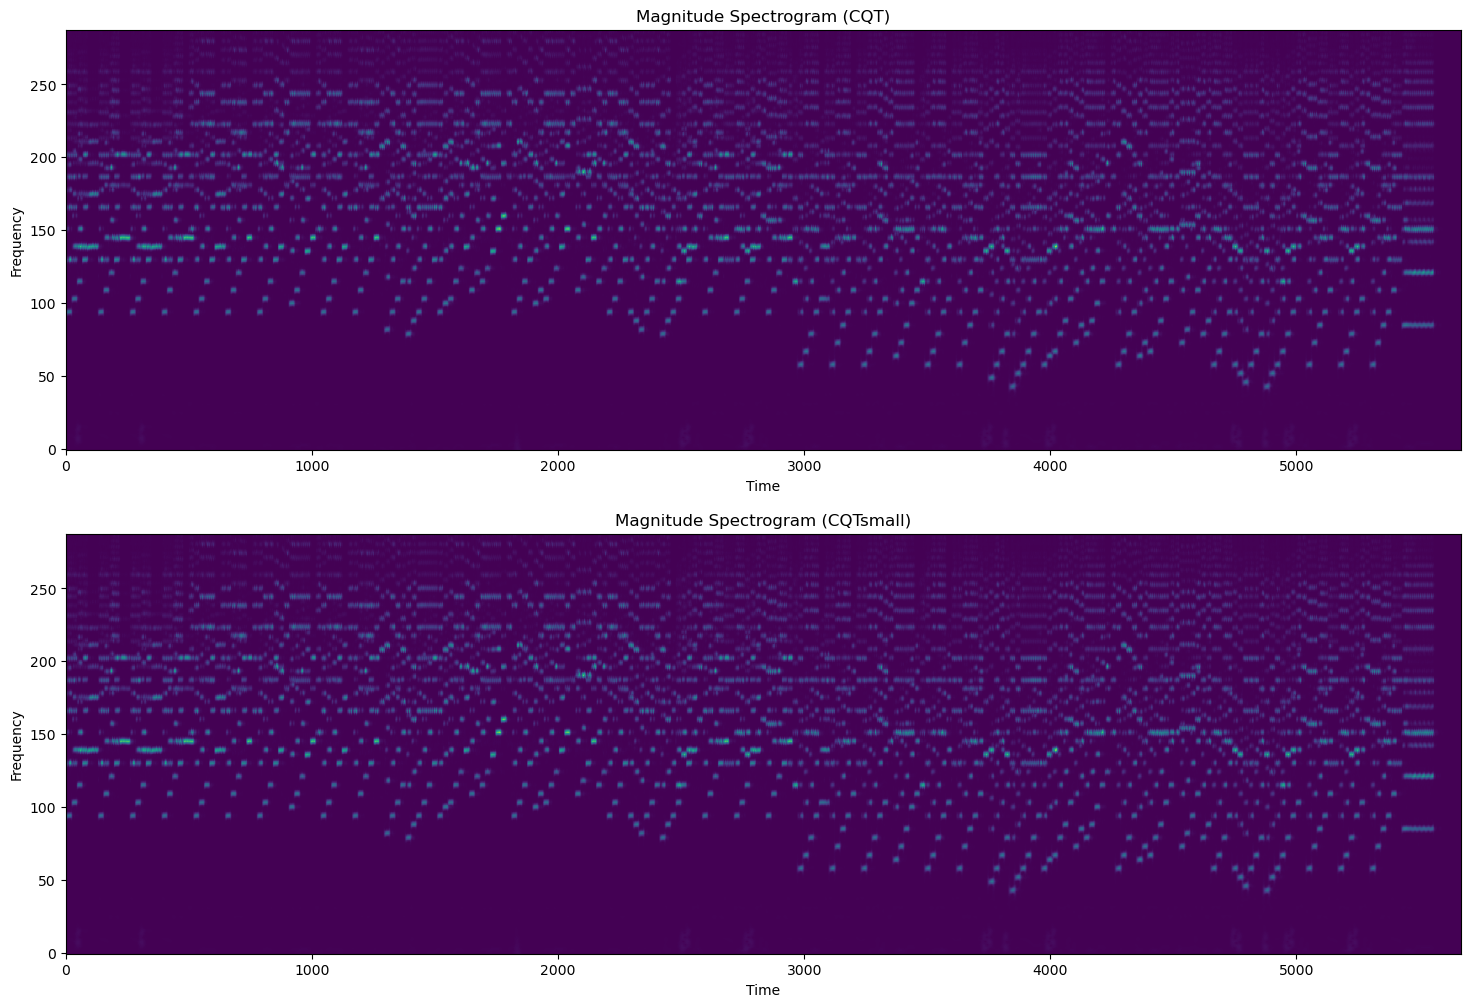

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Plot the first image
plt.subplot(2, 1, 1)
plt.imshow(np.sqrt(mag.detach().numpy()), aspect='auto', origin='lower', cmap='viridis')
plt.title('Magnitude Spectrogram (CQT)')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Plot the second image
plt.subplot(2, 1, 2)
plt.imshow(np.sqrt(magsmall.detach().numpy()), aspect='auto', origin='lower', cmap='viridis')
plt.title('Magnitude Spectrogram (CQTsmall)')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

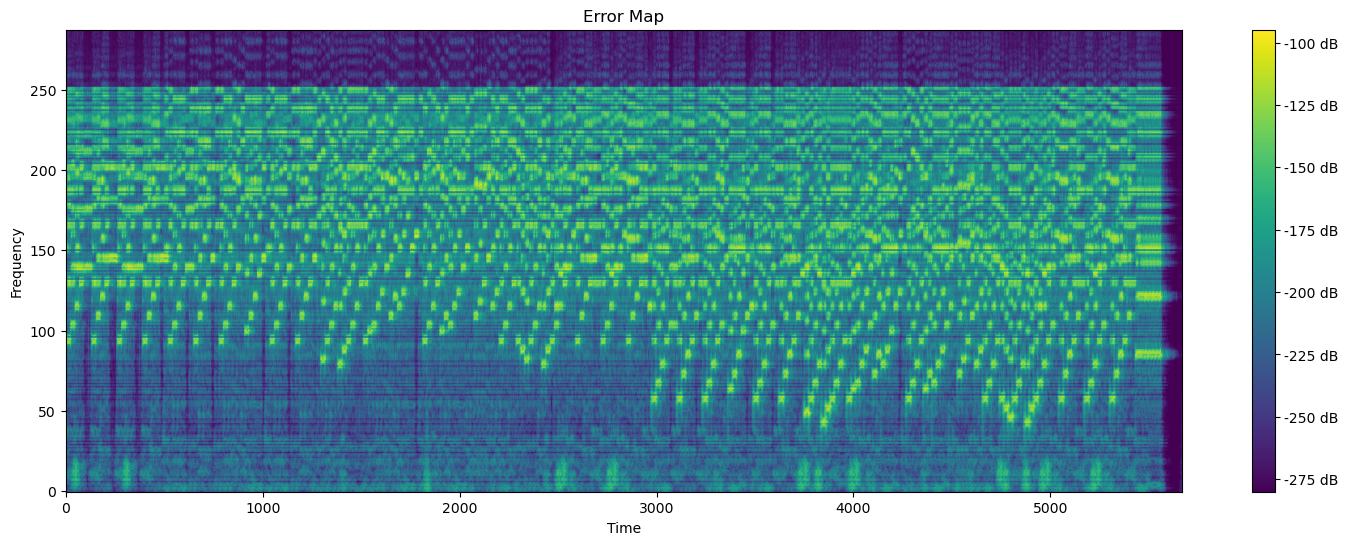

In [7]:
# 绘制误差图
error_map = (mag - magsmall).detach().abs().numpy()
log_error_map = 20 * np.log10(error_map + 1e-14)
plt.imshow(log_error_map, aspect='auto', origin='lower', cmap='viridis')
plt.title('Error Map')
plt.xlabel('Time')
plt.gcf().set_size_inches(18, 6)
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [14]:
total_error = torch.sum((mag - magsmall).pow(2))
print("Total error: ", total_error.item())
# 定义优化器
optimizer = torch.optim.Adam(cqtsmall.parameters(), lr=1e-3, weight_decay=1e-6)
# 清零梯度
optimizer.zero_grad()
# 反向传播
total_error.backward()
# 更新参数
optimizer.step()
print("Backpropagation and optimization step completed.")

Total error:  0.0016289935447275639
Backpropagation and optimization step completed.


In [9]:
for name, param in cqtsmall.named_parameters():
    if param.grad is not None:
        print(f"Parameter: {name}, Gradient: {param.grad}")
        hasnan = torch.isnan(param.grad)
        if hasnan.any():
            nan_count = hasnan.sum().item()
            print(f"Number of NaN values: {nan_count} / {param.shape}")
    else:
        print(f"Parameter: {name} has no gradient")

Parameter: cqt_kernels, Gradient: tensor([[[-1.0449e-07,  4.3322e-07,  4.1970e-07,  ...,  4.1329e-07,
           5.5083e-07,  1.9116e-08]],

        [[-3.9469e-07,  1.6181e-07,  4.8510e-07,  ...,  1.0194e-06,
           8.1222e-07, -1.6840e-07]],

        [[ 2.9285e-06,  3.1472e-06, -7.2148e-07,  ...,  2.9266e-06,
           2.0246e-07, -2.5513e-06]],

        ...,

        [[ 3.1998e-07, -3.8948e-08, -3.0661e-07,  ...,  2.2233e-07,
          -1.9340e-08, -2.6267e-07]],

        [[ 2.7245e-08, -7.9291e-08, -1.0442e-07,  ..., -4.4096e-08,
          -7.5255e-08, -2.3452e-08]],

        [[-8.8695e-08, -3.5401e-07,  2.6953e-07,  ..., -4.8661e-07,
           2.2581e-07, -8.5692e-08]]])
Parameter: iir_num, Gradient: tensor([-1.5047e-05, -1.9557e-05,  1.5196e-06,  4.4938e-05,  8.9083e-05,
         1.0770e-04,  8.9084e-05,  4.4937e-05,  1.5197e-06, -1.9557e-05,
        -1.5047e-05])
